# Predict loan default

 ## load the raw data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('./data/sample_200_0k_20170120.csv')
df['id'] = df.index.values + 1


In [3]:
# create default indicator using the field "MaxOverDueDays"
days_default_point = 90
df = (
    df.assign(is_default=lambda x: x.MaxOverDueDays.apply(lambda y: 1 if y > days_default_point else 0))
    .drop(columns=['MaxOverDueDays'])
)
print(df.is_default.value_counts() / df.shape[0])


0    0.844415
1    0.155585
Name: is_default, dtype: float64


In [4]:
# covert fields for date info to datetime foramt
l_date = [col for col in df.columns if 'date' in col]
for col in l_date:
    df[col] = pd.to_datetime(df[col]).dt.date


 ## data exploration and feature engineering
 
 four kinds of features:
 1. demographic information
 2. geographic information(latitude, longtitude, zipcode, distance)
 3. aggregation features: numeric features (avg, std, cnt)
     3.1 income, income_nation, income_area,
     3.2 sale_house_price(5000, 10000), sale_apartment_price(5000, 10000),
     3.3 rent_house_price(5000, 10000), rent_apartment_price(5000, 10000)
 4. previous: need to extract and transform the data in the column "previous"

### missing data

In [5]:
def check_missing_data(df):
    missing = (
        df.isnull()
        .sum()
        .sort_values(ascending=False)
    )
    percent = (
        df.isnull().sum() / 
        df.isnull().count()
        .sort_values(ascending=False)
    )
    res = pd.concat([missing, percent], axis=1, keys=['Missing', 'Percent'])
    res = res.loc[res.Missing > 0, :]
    return res

In [6]:
df_missing_data = check_missing_data(df)
print(df_missing_data)


                            Missing   Percent
previous                     121022  0.605110
MainBusinessSinceYear        105317  0.526585
EmploymentSinceYear           91140  0.455700
jobpos                        85155  0.425775
std_income                     4300  0.021500
avg_income                     4300  0.021500
avg_income_cnt                 4300  0.021500
avg_income_area_cnt            4182  0.020910
std_icnome_area                4182  0.020910
avg_income_area                4182  0.020910
company_long                   4181  0.020905
distance_residence_company     4181  0.020905
company_lat                    4181  0.020905
companyzipcode                 4181  0.020905
jobtypeid                       137  0.000685
std_income_nation               118  0.000590
avg_income_nation               118  0.000590
avg_income_nation_cnt           118  0.000590
spouseincome                      8  0.000040
maritalstatus                     8  0.000040


 2 fields with considerable missing data are "MainBusinessSinceYear" and "EmploymentSinceYear", but I observed that many sample at least have 1 field out of the 2.
 I did a quick check to find out how many samples have no information in both fields

In [7]:
df_temp = df.loc[:, ['EmploymentSinceYear', 'MainBusinessSinceYear']]
print(pd.notnull(df_temp).all(axis=1).value_counts())
print(pd.notnull(df_temp).any(axis=1).value_counts())
del df_temp


False    196427
True       3573
dtype: int64
True     199970
False        30
dtype: int64


 from the result above, we can find that only 30 samples don't have any information and 199970 samples have useful data

In [8]:
# use these 2 fields to create a new features "work_since_year"
df['work_since_year'] = np.minimum(df.EmploymentSinceYear.fillna(9999), df.MainBusinessSinceYear.fillna(9999)).astype('int')

# use the median value to replace the abnormal value
medval_work_since_year = df['work_since_year'].median()
df['work_since_year'] = df['work_since_year'].replace([0, 9999], medval_work_since_year)

# drop the fields "EmploymentSinceYear" and "MainBusinessSinceYear"
df = df.drop(columns=['EmploymentSinceYear', 'MainBusinessSinceYear'])


In [9]:
# jobpos, I find that the missing percentage of this field is around 43%, so I try to set "Missing" as one category 
df['jobpos'] = df.jobpos.fillna('Missing')

# since the percentage of samples with missing data of these features is around 2%, I just use the most common categories/values to fill the missing entries
df['jobtypeid'] = df.jobtypeid.fillna('Others')
df['maritalstatus'] = df.maritalstatus.fillna('MARRIED')
df['spouseincome'] = df.spouseincome.fillna(0)
df['distance_residence_company'] = df.distance_residence_company.fillna(0)

# derived features with missing data, the percentage is also very low, use median values to fill
cols_derived_with_missing = [col for col in df_missing_data.index.values if (('avg' in col) or ('std' in col) or ('cnt' in col))]
df.loc[:, cols_derived_with_missing] = (
    df.loc[:, cols_derived_with_missing]
    .apply(lambda x: x.fillna(x.median()))
    )

# company zip, longitude and latitude, low percentage, use median values to fill
cols_geo_with_missing = ['companyzipcode', 'company_long', 'company_lat']
df.loc[:, cols_geo_with_missing] = (
    df.loc[:, cols_geo_with_missing]
    .apply(lambda x: x.fillna(x.median()))
    )


In [10]:
# check missing data again
df_missing_data = check_missing_data(df)
print(df_missing_data)


          Missing  Percent
previous   121022  0.60511


 now only the field "previous" still has missing data.
 The information in this field seems useful, I will transform the data and explore in the later part instead of simply handle it.

 ### 1. demographic information

In [11]:
# create 3 new features: 
# age: current age of the customer
# age_first_app: age when the customer first apply loans
# years_since_app: number of years the customer have applied loans

current_date = pd.datetime.now()

df = (
    df.assign(
        age=lambda x: (pd.Series(current_date, index=x.index).dt.date - x.birthdate).apply(lambda y: int(y.days / 365)),
        age_first_app=lambda x: (x.newapplicationdate - x.birthdate).apply(lambda y: int(y.days / 365)),
        years_since_app=lambda x: (pd.Series(current_date, index=x.index).dt.date - x.newapplicationdate).apply(lambda y: y.days / 365))
    .drop(columns=['birthdate', 'newapplicationdate'])
)


<ipython-input-11-c8d794455dba>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  current_date = pd.datetime.now()


In [12]:
# create features about income of the customer:
# monthly_income_per_family_member: monthly family income divided number of the family
# income_over_workingyears: monthly income divided by the number of years during working
# income_over_nationlevel: monthly income divided by the averge income of the nation
# income_over_arealevel: monthly income divided by the averge income of the area
df = (
    df.assign(
        monthly_income_per_family_member=lambda x: (x.monthlyfixedincome + x.monthlyvariableincome + x.spouseincome) / (x.numofdependence + 1),
        income_over_workingyears=lambda x: (x.monthlyfixedincome + x.monthlyvariableincome) / (current_date.year - x.work_since_year),
        income_over_nationlevel=lambda x: (x.monthlyfixedincome + x.monthlyvariableincome) / x.avg_income_nation,
        income_over_arealevel=lambda x: (x.monthlyfixedincome + x.monthlyvariableincome) / x.avg_income_area
    )
)


In [13]:
# convert the fields "numofdependence" and "homestatus" from numeric type to categorical type
df.loc[:, ['numofdependence', 'homestatus']] = \
    df.loc[:, ['numofdependence', 'homestatus']].apply(lambda x: x.astype(object))

# drop the field birthplace as the number of categories of this field is too big...
df = df.drop(columns=['birthplace'])


 ### 2. geographic features

In [14]:
def check_correlation(df, cols):
    return df[cols].corr()


In [15]:
# There are 3 types of geographic information in the dataset: residence, company, legal
# quick check the correlation of these 3 types

print(df.pipe(check_correlation, ['residence_lat', 'company_lat', 'legal_lat']))
print(df.pipe(check_correlation, ['residence_long', 'company_long', 'legal_long']))
print(df.pipe(check_correlation, ['residencezipcode', 'companyzipcode', 'legalzipcode']))

               residence_lat  company_lat  legal_lat
residence_lat       1.000000     0.976563   0.992402
company_lat         0.976563     1.000000   0.970267
legal_lat           0.992402     0.970267   1.000000
                residence_long  company_long  legal_long
residence_long        1.000000      0.969794    0.992593
company_long          0.969794      1.000000    0.965985
legal_long            0.992593      0.965985    1.000000
                  residencezipcode  companyzipcode  legalzipcode
residencezipcode          1.000000        0.967446      0.994264
companyzipcode            0.967446        1.000000      0.962219
legalzipcode              0.994264        0.962219      1.000000


 from the correlation matrix, we can only keep one type of latitude/longitude/zipcode data, to reduce the number of features
 say only keep the type "legal"

In [16]:
df = df.drop(columns=['residence_lat', 'company_lat', 'residence_long', 'company_long', 'residencezipcode', 'companyzipcode'])


<AxesSubplot:xlabel='legal_long', ylabel='legal_lat'>

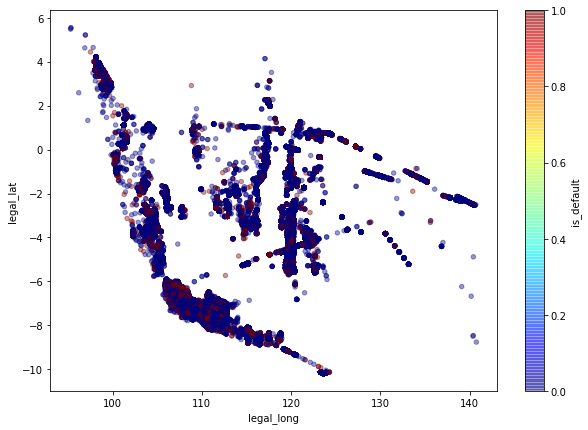

In [17]:
# now I try to create a scatterplot to visualze the data
df.plot(kind='scatter', x='legal_long', y='legal_lat', alpha=0.4,
    figsize=(10, 7), c='is_default', cmap=plt.get_cmap('jet'), colorbar=True, sharex=False)


 It seems that the default rate of area from (106, -6) to (118, -8) is high. Below is a quick check:

In [18]:
flag_high_default = (df.legal_long < 118) & (df.legal_lat < -6) & \
    (df.legal_long > 106) & (df.legal_lat > -8)

df_temp = df.loc[flag_high_default, :]

print(df_temp.is_default.value_counts() / df_temp.shape[0])
del df_temp


0    0.80777
1    0.19223
Name: is_default, dtype: float64


 The default rate in this area is 19.2%, 23% higher than the default rate of the population (15.6%).
 According to this, I will create a feature "high_default_area"

In [19]:
df['high_default_area'] = 0
df.loc[flag_high_default, 'high_default_area'] = 1


 ### 3. derived features

In [20]:
def scale_numeric_cols(df, cols):
    cols_mean = df[cols].mean()
    cols_std = df[cols].std()
    df.loc[:, cols] = (df.loc[:, cols] - cols_mean) / cols_std
    return df


In [21]:
# I noticed that the values of the derived features are quite big  
# try to scale them to smaller level
cols_derived = [col for col in df.columns if (('avg' in col) or ('std' in col) or ('cnt' in col))]
cols_income = [col for col in df.columns if (('income' in col) and (col not in cols_derived))]

df = (
    df.pipe(scale_numeric_cols, cols_derived)
    .pipe(scale_numeric_cols, cols_income)
)


 ### 4. previous application record

In [22]:
def transform_data_prev(df):
    """
    This function is used for extracting information from the original column "previous", 
    and transforming to a standard dataframe for analysis 
    """

    # split using separator ';' because 1 customer may have multiple previous application
    df_temp = (
        df.previous.dropna()
        .str.split(';', expand=True)
    )
    
    # convert the wide format data to long format data, each application record put into diffrent row
    df_temp = (
        pd.concat([df.id, df_temp], axis=1)
        .pipe(pd.melt, id_vars=['id'])
        .rename(columns={'variable': 'ith_prev_app'})
    )

    # the first previous application starts from 1 instead of 0
    df_temp['ith_prev_app'] += 1
    
    # drop invalid rows
    df_temp = df_temp.loc[pd.notnull(df_temp.value), :]

    # split the information of each previous application record
    # since no additional information about the fields, I simply set them to prev_var1, prev_var2 and prev_var3 
    df_temp_val = (
        df_temp.value.str.split(',', expand=True)
        .rename(columns={
            0: 'prev_app_time',
            1: 'prev_var1',
            2: 'prev_var2',
            3: 'prev_var3'})
    )

    df_prev = (
        pd.concat([df_temp.loc[:, ['id', 'ith_prev_app']], df_temp_val], axis=1)
        .reset_index(drop=True)
    )

    # set datatype for the fields
    df_prev.loc[:, 'ith_prev_app'] = \
        df_prev.loc[:, 'ith_prev_app'].astype('int')
    
    df_prev.loc[:, ['prev_var1', 'prev_var2', 'prev_var3']] = \
        df_prev.loc[:, ['prev_var1', 'prev_var2', 'prev_var3']].apply(lambda x: x.astype('float'))

    # create feature 'years_since_app_prev': the number of years from previous application dates onwards
    current_date = pd.datetime.now()
    
    df_prev['prev_app_time'] = pd.to_datetime(df_prev.prev_app_time).dt.date
    
    df_prev['years_since_app_prev'] = (
        (pd.Series(current_date, index=df_prev.index).dt.date - df_prev.prev_app_time).apply(lambda y: y.days / 365)
    )

    return df_prev


def aggregate_data_prev(df):
    """
    This function is for generating new features of the previous application data 
    by aggregating the numeric features 
    """

    func_agg = {
        'ith_prev_app': ['max', 'mean'],
        'years_since_app_prev': ['max', 'mean'],
        'prev_var1': ['min', 'max', 'mean', 'sum'],
        'prev_var2': ['min', 'max', 'mean'],
        'prev_var3': ['min', 'max', 'mean', 'sum']
    }

    df_agg = (
        df.groupby('id')
        .agg(func_agg)
    )
    
    # standardize the column names of the derived features
    df_agg.columns = pd.Index([e[0] + "_" + e[1] for e in df_agg.columns])

    return df_agg


In [23]:
# the pipeline below is for extracting, transforming and aggregating data in the "previous" column
# the purpose is to generate new features for the next modelling part 
df_prev_agg = (
    df.pipe(transform_data_prev)
    .pipe(aggregate_data_prev)
)

# scaling 
cols_from_prev = [col for col in df_prev_agg.columns if (('var1' in col) or ('var3' in col))]
df_prev_agg = df_prev_agg.pipe(scale_numeric_cols, cols_from_prev)

# create a new feature "is_prev_app": whether a customer has previous application record, assign 1 if yes, otherwise 0
df['is_prev_app'] = 0
df.loc[df.previous.notnull(), 'is_prev_app'] = 1

# drop the original "previous" column
df = df.drop(columns=['previous'])


<ipython-input-22-4f7881a68302>:50: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  current_date = pd.datetime.now()


now I prepare the data for machine learning algorithms later.

In [24]:
# the pipeline below:
# 1. one-hot encoding for the categorical variables
# 2. merge the derived features from previous application records to the original data
# 3. for customer id without previous application, put 0 to the columns related to previous application 
df = (
    df.pipe(pd.get_dummies)
    .merge(df_prev_agg, how='left', left_on='id', right_index=True)
    .fillna(0)
)


 ## Modelling
 
 I try 2 algorithms random forest and xgboost respectively

In [25]:
# create training set and test set, use the stratified spliting to make the distribution of training and test set similar.
from sklearn.model_selection import train_test_split
X = df.drop(columns=['id', 'is_default'])
y = df['is_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


 ### 1. random forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf_rf = RandomForestClassifier()
param_grid_rf = {'n_estimators': [100, 300], 'max_depth': [4, 6], 'class_weight': ['balanced'], 'random_state': [1]}

grid_search_rf = GridSearchCV(clf_rf, param_grid_rf, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [4, 6],
                         'n_estimators': [100, 300], 'random_state': [1]},
             scoring='roc_auc', verbose=1)

In [27]:
# print the auc of the shortlisted models
for auc, params in zip(grid_search_rf.cv_results_['mean_test_score'], grid_search_rf.cv_results_['params']):
    print(auc, params)
# select the best estimator of gridsearch as the model
model_rf = grid_search_rf.best_estimator_


0.7055630986412048 {'class_weight': 'balanced', 'max_depth': 4, 'n_estimators': 100, 'random_state': 1}
0.7046471286684264 {'class_weight': 'balanced', 'max_depth': 4, 'n_estimators': 300, 'random_state': 1}
0.718086297405259 {'class_weight': 'balanced', 'max_depth': 6, 'n_estimators': 100, 'random_state': 1}
0.7187721251062069 {'class_weight': 'balanced', 'max_depth': 6, 'n_estimators': 300, 'random_state': 1}


 ### check out the AUROC of random forest model

In [28]:
def plot_roc_auc(label, pred):
    
    # construct roc curve and calculate roc_auc
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, _ = roc_curve(label, pred)

    roc_auc = auc(fpr, tpr)
    
    # plot the roc curve and display roc_auc
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


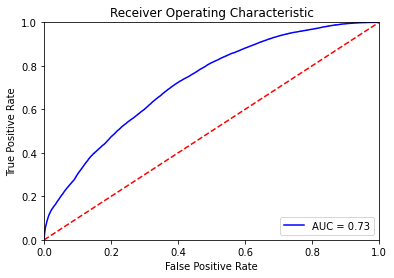

In [29]:
# plot the auc_roc of the training set
y_train_pred_rf = model_rf.predict_proba(X_train)[:, 1]
plot_roc_auc(y_train, y_train_pred_rf)


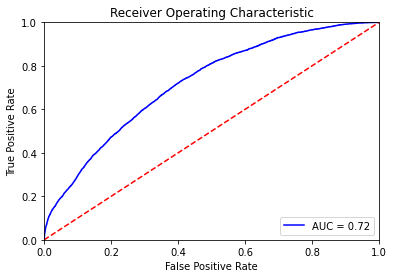

In [30]:
# plot the auc_roc of the test set
y_test_pred_rf = model_rf.predict_proba(X_test)[:, 1]
plot_roc_auc(y_test, y_test_pred_rf)


The auc of test set is 0.72, while auc of training set is 0.73. We may try to see whether the performance of xgboost is better in the following session.

 ### 2. xgboost

In [31]:
import xgboost as xgb

clf_xgb = xgb.XGBClassifier()
param_grid_xgb = [
    {'n_estimators': [50, 200], 'max_depth': [3, 4], 'learning_rate': [0.1], 'random_state': [1]}
]

grid_search_xgb = GridSearchCV(clf_xgb, param_grid_xgb, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 12.7min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [32]:
# print the auc of the shortlisted models
for auc, params in zip(grid_search_xgb.cv_results_['mean_test_score'], grid_search_xgb.cv_results_['params']):
    print(auc, params)
# select the best estimator of gridsearch as the model
model_xgb = grid_search_xgb.best_estimator_


0.7274587601719971 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'random_state': 1}
0.7487146897632864 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'random_state': 1}
0.7351084411626184 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 1}
0.7530581168821415 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'random_state': 1}


 ### check out the AUROC of xgboost model

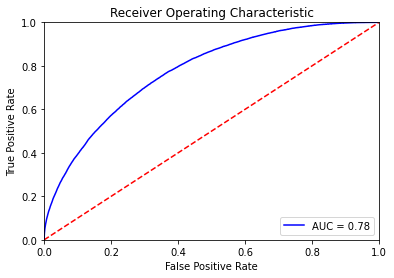

In [33]:
# plot the auc_roc of the training set
y_train_pred_xgb = model_xgb.predict_proba(X_train)[:, 1]
plot_roc_auc(y_train, y_train_pred_xgb)


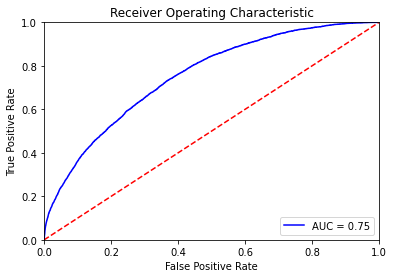

In [34]:
# plot the auc_roc of the test set
y_test_pred_xgb = model_xgb.predict_proba(X_test)[:, 1]
plot_roc_auc(y_test, y_test_pred_xgb)


the auc using xgboost model is higher than the random forest model, but under xgboost model, auc of test set is 3% lower than the one of training set, so still need to fine tune the model to avoid overfitting...

 ### feature importance

In [35]:
def display_top_n_features(arr_feature_names, arr_feature_importances, n_features=20):

    assert len(arr_feature_importances) == len(arr_feature_names) 

    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # construct the dataframe of feature importance info
    df_feature_importance = pd.DataFrame(index=range(len(arr_feature_importances)), columns=['feature', 'importance'])
    df_feature_importance['feature'] = arr_feature_names
    df_feature_importance['importance'] = arr_feature_importances
    # sort by importance of features
    df_top_n_features = df_feature_importance.sort_values(by='importance', ascending=False)[:n_features]

    # plot the barchart of the feature importance dataframe
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=df_top_n_features)
    plt.title('notable features')
    plt.tight_layout()


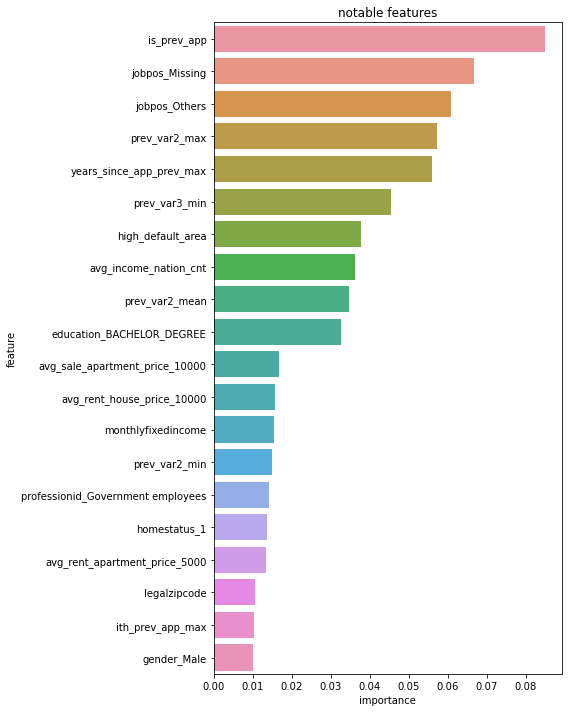

In [38]:
feature_importances = model_xgb.feature_importances_
feature_names = X_train.columns.values
display_top_n_features(feature_names, feature_importances)


## Q&A

### notable features

Based on the above barchart, I found that the previous application information is helpful indicator to predict default risk.

The feature importance of "is_prev_app", "prev_var2_max"(I guess "prev_var2" is the max overdue days of previous application), "prev_var3_mean", "prev_var2_mean" and "ith_prev_app_max" are among the top 20 features selected.

Features "jobpos_Others" and "jobpos_Missing" are also notable indicator, it implies that high risk customers probably won't have specific information of the job positions.

Feature "high_default_area" is important, which is as expected.

### potential drawback

For the data exploration part, I didn't go very deep to the geographic features and derived features. For example, I didn't check throughly about the correlation of the derived features, while I think some of the those features are highly correlated. There must be more good features I didn't discover.

For the modelling part, I only tried 2 types of algorithms and limited combination of parameters sets. The GBDT model also has overfitting issue.

### overfitting

The random forest algorithm result doesn't have obvious overfitting issue, but the xgboost algorithm result does. It is also due to the property of the bagging and boosting algorithms. The other reason is I didn't apply techniques like regularization or early stopping to reduce the risk of overfitting. 

### running time

It takes around 20 minutes to run the whole notebook in my laptop.

### improvement

Firstly I will try to spend more time on analysing the dataset, especially the geographic features and the derived features. 

Secondly I will try to apply regularization and early stopping to reduce the overfitting of the xgboost model. 

Thirdly I will try to add new parameters, like subsample ratios of samples and features, in the model training and selection part. 

Lastly I will try to modulize the data preparation part and model training part, reduce the replicated code (e.g. the code of running random forest and xgboost is very similar.) 